# **Particle-Swarm Optimization 2**

## Bio-Inspired Computing
### Mikel Ignacio Barajas Martínez

### 08/27/24

𝝮

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [121]:
class PSO:
    def __init__(self, n, dim, iterations, c1, c2, w_max, w_min, f, lower_bound=-5.12, upper_bound=5.12, early_stop=False, solution=[0.0, 0.0]):
        
        # problem parameters
        self.n = n - 1
        self.dim = dim
        self.iterations = iterations
        self.true_iterations = iterations
        self.tolerance = 1
        self.min_tolerance = 1e-6
        self.upper_bound = solution[0] + upper_bound
        self.lower_bound = solution[0] + lower_bound
        self.solution = solution

        # acceleration coefficients
        self.c1 = c1
        self.c2 = c2

        # inertia weight
        self.w_max = w_max
        self.w_min = w_min

        # objective function
        self.f = f

        # particle data
        self.p = None
        self.v = None
        self.p_best_positions = None
        self.p_best_values = None
        self.g_best_position = None
        self.g_best_value = np.inf

        # history
        self.p_history = []
        self.v_history = []
        self.g_best_history = []

        # plots
        self.history = []
        self.p_plot = None
        self.v_plot = None
        self.g_best_plot = None

        # misc
        self.early_stop = early_stop


    def setup(self):

        # initialize particles
        self.p = np.random.uniform(self.lower_bound, self.upper_bound, (self.n, self.dim))
        self.v = np.random.uniform(-1, 1, (self.n, self.dim))

        # initialize personal best positions
        self.p_best_positions = self.p.copy()
        self.p_best_values = self.f(self.p)

        # initialize global best position
        self.g_best_position = self.p_best_positions[self.p_best_values.argmin()]
        self.g_best_value = self.p_best_values.min()

        self.tolerance = 1
    
    def update(self, i):

        # update velocity
        w = self.w_max - (self.w_max - self.w_min) * i / self.iterations
        r1 = np.random.uniform(0, 1, (self.n, self.dim))
        r2 = np.random.uniform(0, 1, (self.n, self.dim))
        self.v = w * self.v + self.c1 * r1 * (self.p_best_positions - self.p) + self.c2 * r2 * (self.g_best_position - self.p)

        # update position
        self.p = self.p + self.v

        # apply boundary conditions
        self.p = np.clip(self.p, self.lower_bound, self.upper_bound)

        # update personal best
        values = self.f(self.p)
        mask = values < self.p_best_values
        self.p_best_positions[mask] = self.p[mask]
        self.p_best_values[mask] = values[mask]

        # tolerance
        if i > self.iterations / 2 and self.early_stop:
            self.tolerance = abs(self.p_best_values.min() - self.g_best_value);

        # update global best
        if self.p_best_values.min() < self.g_best_value:
            self.g_best_position = self.p_best_positions[self.p_best_values.argmin()]
            self.g_best_value = self.p_best_values.min()

        self.history.append(self.g_best_value)
        self.p_history.append(self.p.copy())
        self.v_history.append(self.v.copy())
        self.g_best_history.append(self.g_best_position)

    def run(self):

        for i in range(self.iterations):
            self.update(i)

            if self.tolerance < self.min_tolerance:
                self.true_iterations = i
                break

            yield i, self.g_best_position, self.g_best_value


    def optimize(self, verbose=True):

        self.setup()

        print(f'PSO with parameters n={self.n}, ite={self.iterations}, c1={self.c1}, c2={self.c2}, wmax={self.w_max}, wmin={self.w_min}')

        start_time = time.time()
        for i, g_best_position, g_best_value in self.run():
            if verbose:
                print(f'Iteration {i + 1}: {g_best_value} ({g_best_position})')
                
        print(f'Time taken: {time.time() - start_time:.6f} seconds')
        print(f'Global best value: {self.g_best_value} at {self.g_best_position}')

    def __lt__(self, other):
        return self.g_best_value > other.g_best_value

    def plot_convergence(self):
        plt.plot(self.history)
        plt.xlabel('Iteration')
        plt.ylabel('Best f-Value')
        plt.show()

    def animate(self, i):

        self.p_plot.set_offsets(self.p_history[i])
        self.v_plot.set_offsets(self.p_history[i])
        self.v_plot.set_UVC(self.v_history[i][:, 0], self.v_history[i][:, 1])
        # self.g_best_plot.set_offsets([g_best_position_history[i]])
        return self.p_plot, self.v_plot #, self.g_best_plot

    def plot_animation(self, format='mp4', fps=15, save=True, filename='pso'):

        plot_range = np.linspace(self.lower_bound, self.upper_bound, 100)
        x1, x2 = np.meshgrid(plot_range, plot_range)
        X = np.column_stack((x1.ravel(), x2.ravel()))
        Z = self.f(X).reshape(x1.shape)
        
        fig, ax = plt.subplots()

        contour = ax.contourf(x1, x2, Z, levels=1000, cmap='coolwarm')
        # CS = ax.contour(x1, x2, Z, levels=10, colors='white', linewidths=0.5, alpha=0.7)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')

        fig.colorbar(contour, ax=ax)

        ax.set_aspect('equal', adjustable='box')

        self.p_plot = ax.scatter(self.p[:, 0], self.p[:, 1], color='black', animated=True, alpha=0.5)
        self.v_plot = ax.quiver(self.p[:, 0], self.p[:, 1], self.v[:, 0], self.v[:, 1], color='black', alpha=0.7, width=0.005, angles='xy', scale_units='xy', scale=1, animated=True)
        # g_best_plot = ax.scatter(g_best_position[0], g_best_position[1], color='red', marker='x', label='global best', alpha=0.7, animated=True)

        anim = FuncAnimation(fig, self.animate, frames=self.true_iterations, interval=100, blit=True, repeat=True)

        self.min_plot = ax.scatter(self.solution[0], self.solution[1], color='black', marker='*', label='true minimum', alpha=0.7)

        # plt.legend()

        if save:
            if format == 'gif':
                anim.save(f'{filename}.gif', writer='imagemagick', fps=fps)
            else:
                anim.save(f'{filename}.{format}', writer='ffmpeg', fps=fps)

        plt.show()

    def plot_frame(self, i):

        plot_range = np.linspace(self.lower_bound, self.upper_bound, 100)
        x1, x2 = np.meshgrid(plot_range, plot_range)

        X = np.column_stack((x1.ravel(), x2.ravel()))
        Z = self.f(X).reshape(x1.shape)
        
        fig, ax = plt.subplots()

        contour = ax.contourf(x1, x2, Z, levels=1000, cmap='coolwarm')
        # CS = ax.contour(x1, x2, Z, levels=10, colors='white', linewidths=0.5, alpha=0.7)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')

        fig.colorbar(contour, ax=ax)

        ax.set_aspect('equal', adjustable='box')

        p_plot = ax.scatter(self.p_history[i][:, 0], self.p_history[i][:, 1], color='black', alpha=0.5)
        v_plot = ax.quiver(self.p_history[i][:, 0], self.p_history[i][:, 1], self.v_history[i][:, 0], self.v_history[i][:, 1], color='black', alpha=0.7, width=0.005, angles='xy', scale_units='xy', scale=1)
        g_best_plot = ax.scatter(self.g_best_history[i][0], self.g_best_history[i][1], color='red', marker='x', label='global best', alpha=0.7)
        min_plot = ax.scatter(self.solution[0], self.solution[1], color='black', marker='*', label='true minimum', alpha=0.7)

        plt.title(f'Iteration {i + 1}')
        plt.legend(loc='lower left')

        plt.show

    def plot_objective_function(self):

        plot_range = np.linspace(self.lower_bound, self.upper_bound, 100)
        x1, x2 = np.meshgrid(plot_range, plot_range)
        X = np.column_stack((x1.ravel(), x2.ravel()))

        Z = self.f(X).reshape(x1.shape)

        # 3D plot

        fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
        ax.plot_surface(x1, x2, Z, cmap='coolwarm')

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('f(x1, x2)')

        offset = Z.min()
        contour = ax.contour(x1, x2, Z, zdir='z', offset=offset, linewidths=0.4, levels=10, cmap='coolwarm')

        ax.view_init(elev=20, azim=-45)
        ax.set_box_aspect([2, 2, 1])

        plt.show()

        # 2D contour plot

        fig, ax = plt.subplots()

        contour = ax.contourf(x1, x2, Z, levels=1000, cmap='coolwarm')
        # CS = ax.contour(x1, x2, Z, levels=10, colors='white', linewidths=0.5, alpha=0.7)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')

        fig.colorbar(contour, ax=ax)

        ax.set_aspect('equal', adjustable='box')

        plt.show()



## Problemas

In [122]:
penalty = 1e9

### Problema 1: Concurso de alambre

Max $xy$

$ 2x+2y \le 20 $

Solución: $x=5, y=5$

In [123]:
def f1(x):

    X = np.atleast_2d(x)

    val = -(X[:, 0] * X[:, 1])

    r0 = 2 * X[:, 0] + 2 * X[:, 1] - 20

    val[r0 > 0] = val[r0 > 0] + penalty * r0[r0 > 0]

    return val

PSO with parameters n=4, ite=10, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 5.214105864589806 ([-0.5101125  10.22148228])
Iteration 2: 1.8087013414176711 ([-0.18408506  9.82535649])
Iteration 3: -0.7296493355124407 ([0.07673689 9.50845586])
Iteration 4: -7.745416519673291 ([0.97406605 7.95163383])
Iteration 5: -7.745416519673291 ([0.97406605 7.95163383])
Iteration 6: -7.745416519673291 ([0.97406605 7.95163383])
Iteration 7: -8.036111551073265 ([0.96800899 8.30169102])
Iteration 8: -8.789651867671472 ([1.07645567 8.16536353])
Iteration 9: -10.63856028896513 ([1.29043939 8.24413792])
Iteration 10: -11.52850272425769 ([1.40626359 8.19796713])
Time taken: 0.002257 seconds
Global best value: -11.52850272425769 at [1.40626359 8.19796713]


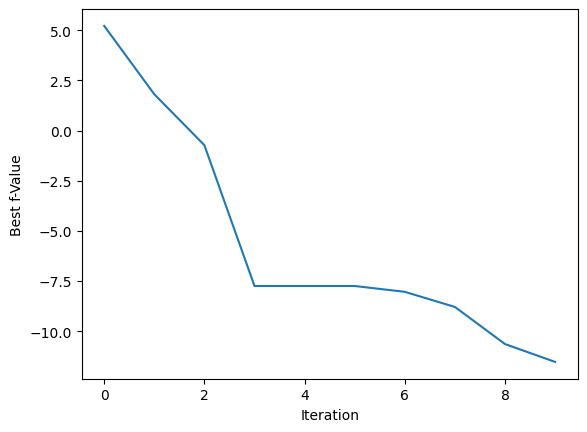

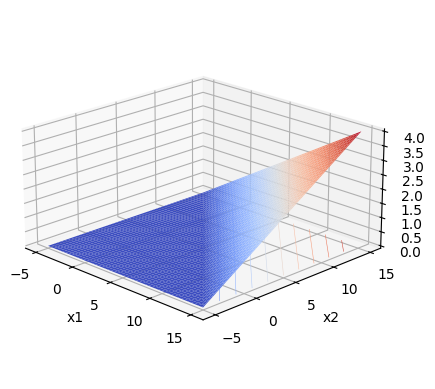

Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).


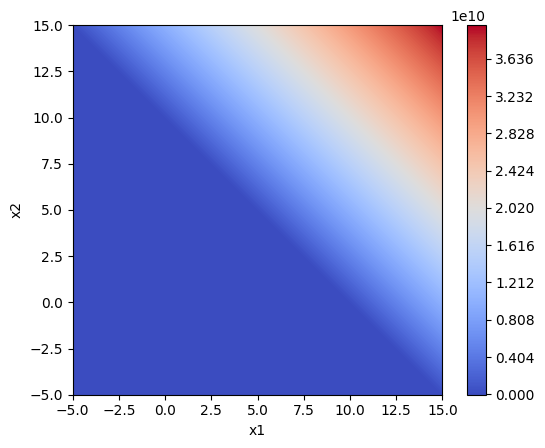

Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).


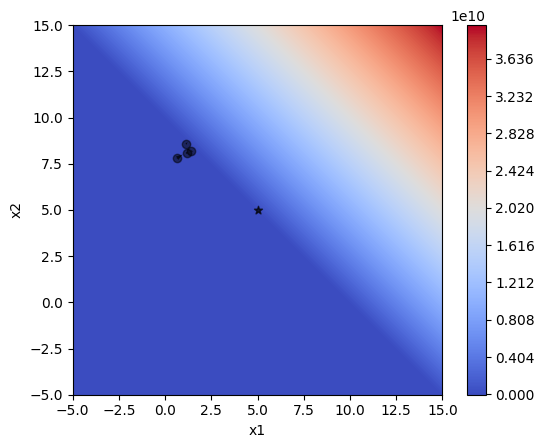

Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).


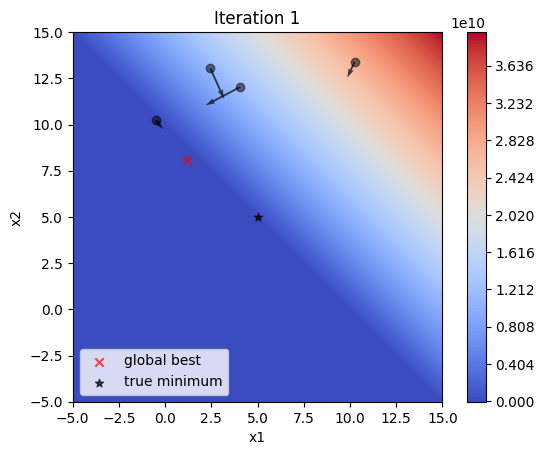

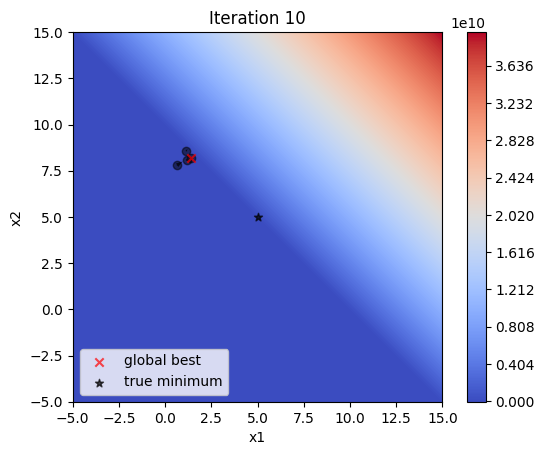

In [124]:
pso = PSO(n=5, dim=2, iterations=10, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f1, lower_bound=-10, upper_bound=10, solution = [5.0, 5.0], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f1')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=9, ite=100, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: -15.747647192289396 ([6.92132563 2.2752357 ])
Iteration 2: -17.891980648893025 ([5.53068823 3.23503692])
Iteration 3: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 4: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 5: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 6: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 7: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 8: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 9: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 10: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 11: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 12: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 13: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 14: -21.374575933385515 ([6.73463694 3.1738275 ])
Iteration 15: -21.712626249299984 ([6.59310639 3.29323159])
Iteration 16: -21.712626249299984 ([6.59

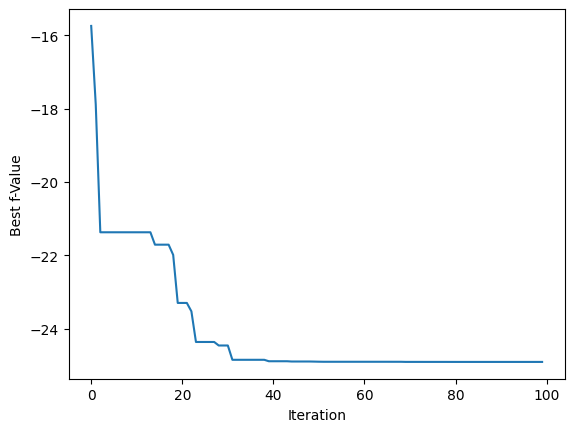

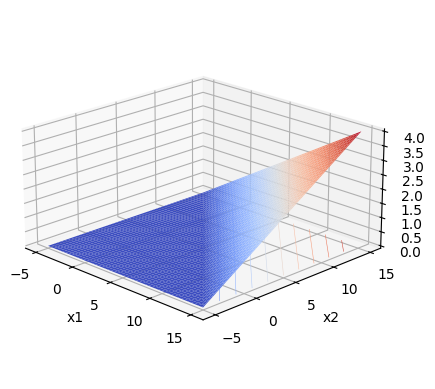

Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).


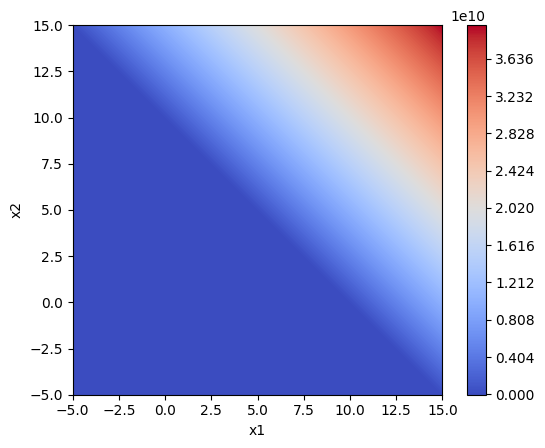

Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).


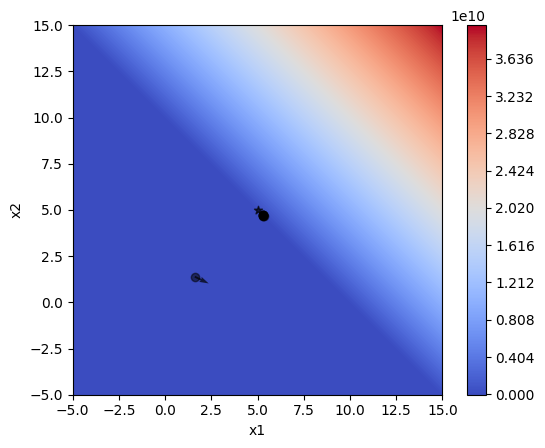

Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).


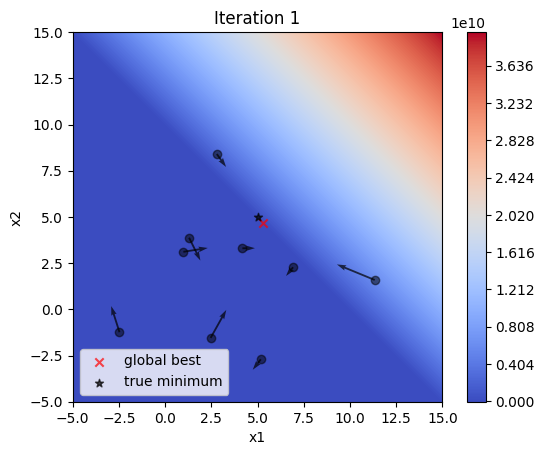

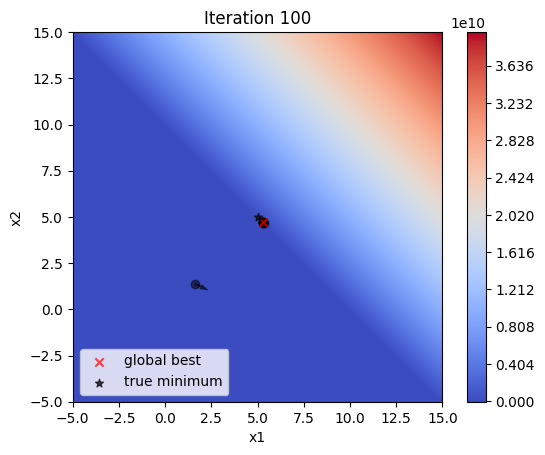

In [125]:
pso = PSO(n=10, dim=2, iterations=100, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f1, lower_bound=-10, upper_bound=10, solution = [5.0, 5.0], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f1')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=99, ite=100, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: -20.278733341093783 ([4.99561995 4.05930266])
Iteration 2: -21.938916445302116 ([4.23205849 5.18398234])
Iteration 3: -24.458634717807506 ([4.98808479 4.90341198])
Iteration 4: -24.567136241518966 ([5.0184303  4.89538258])
Iteration 5: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 6: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 7: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 8: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 9: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 10: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 11: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 12: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 13: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 14: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 15: -24.779092903351003 ([4.85477908 5.1040619 ])
Iteration 16: -24.779092903351003 ([4.8

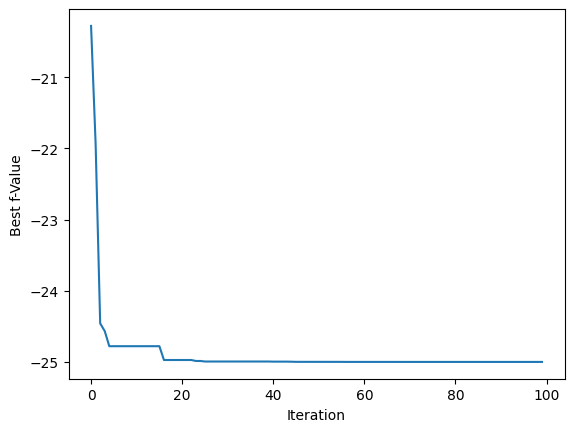

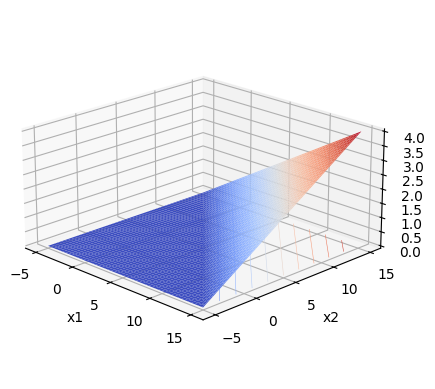

Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).


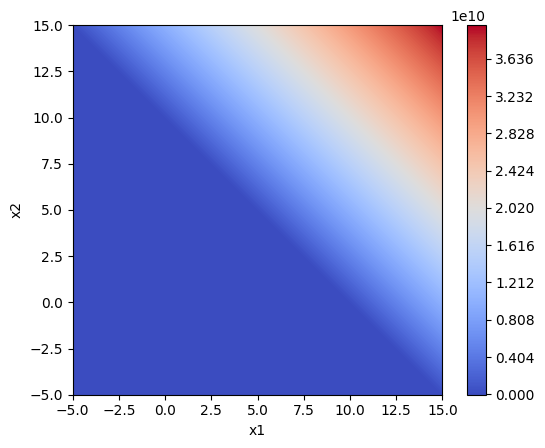

Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).


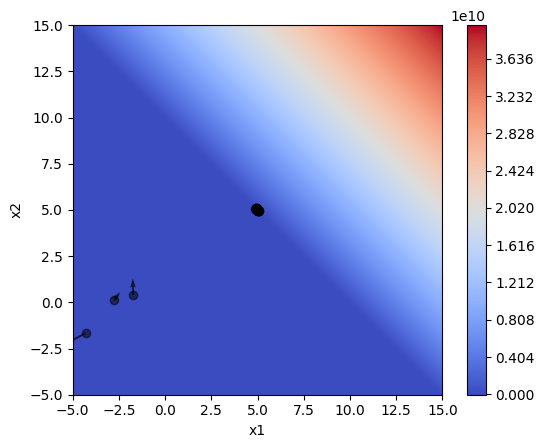

Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1002 ticks ([-40000000.0, ..., 40000000000.0]), which exceeds Locator.MAXTICKS (1000).


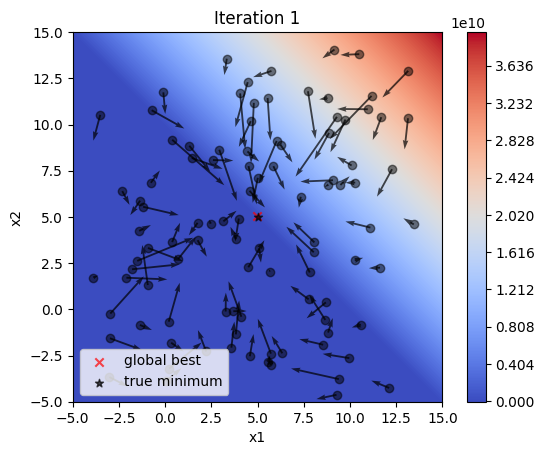

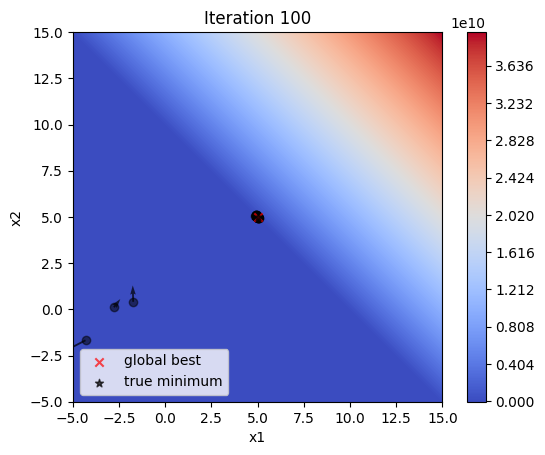

In [126]:
pso = PSO(n=100, dim=2, iterations=100, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f1, lower_bound=-10, upper_bound=10, solution = [5.0, 5.0], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f1')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

### Problema 2: Crercar un solar rectangular

Max $xy$

$2x + 2y \le 400$

Solución: $x=100, y=100$

In [127]:
def f2(x):

    X = np.atleast_2d(x)

    val = -(X[:, 0] * X[:, 1])

    r0 = 2 * X[:, 0] + 2 * X[:, 1] - 400

    val[r0 > 0] = val[r0 > 0] + penalty * r0[r0 > 0]

    return val

PSO with parameters n=4, ite=10, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: -9652.330515037274 ([113.36135209  85.14657189])
Iteration 2: -9652.330515037274 ([113.36135209  85.14657189])
Iteration 3: -9825.66600685494 ([109.88771291  89.41551104])
Iteration 4: -9825.66600685494 ([109.88771291  89.41551104])
Iteration 5: -9825.66600685494 ([109.88771291  89.41551104])
Iteration 6: -9825.66600685494 ([109.88771291  89.41551104])
Iteration 7: -9825.66600685494 ([109.88771291  89.41551104])
Iteration 8: -9921.716514001699 ([108.63359868  91.33193261])
Iteration 9: -9921.716514001699 ([108.63359868  91.33193261])
Iteration 10: -9921.716514001699 ([108.63359868  91.33193261])
Time taken: 0.001738 seconds
Global best value: -9921.716514001699 at [108.63359868  91.33193261]


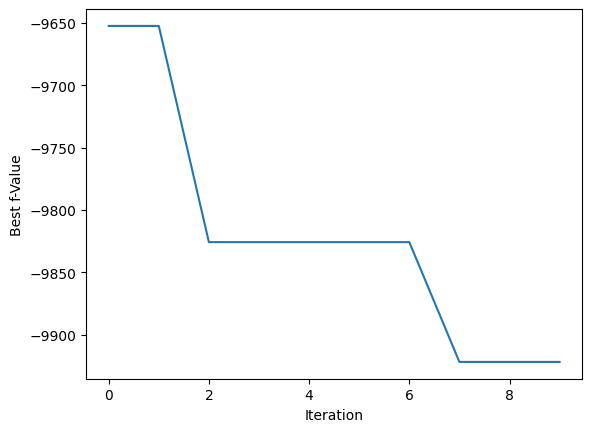

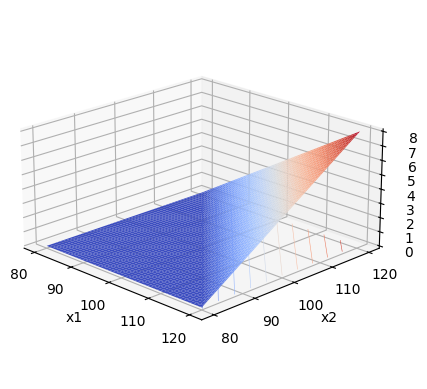

Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).


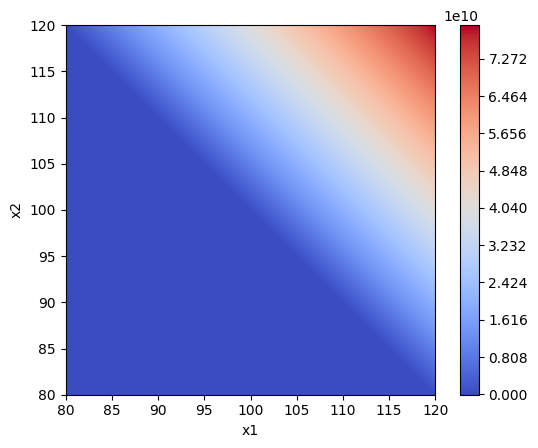

Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).


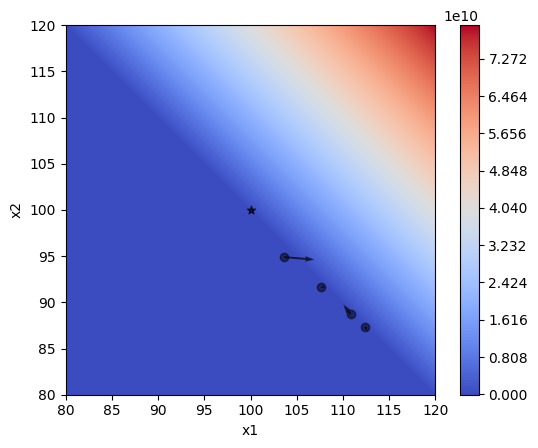

Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).


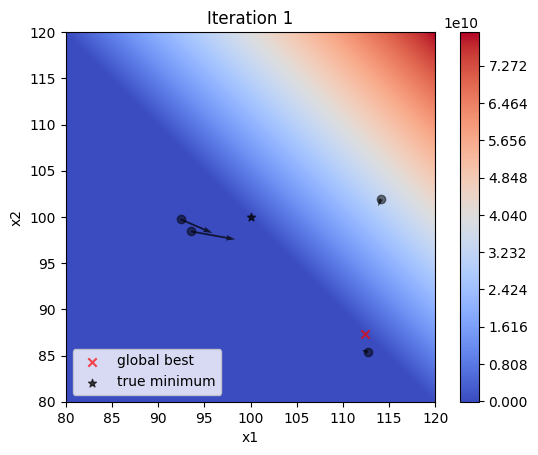

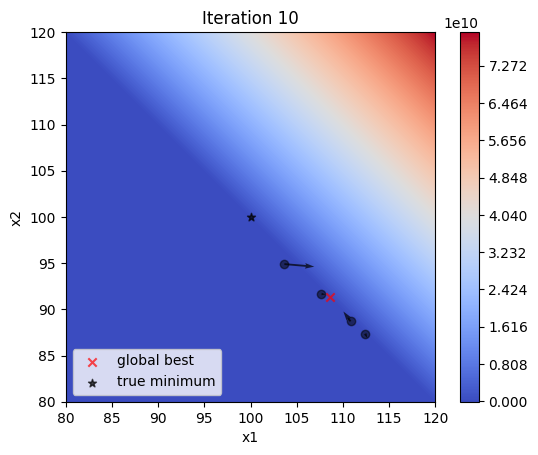

In [128]:

pso = PSO(n=5, dim=2, iterations=10, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f2, lower_bound=-20, upper_bound=20, solution = [100.0, 100.0], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f2')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=9, ite=100, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: -9726.142146483355 ([97.69835215 99.55277579])
Iteration 2: -9880.799109925103 ([101.14507098  97.68937838])
Iteration 3: -9912.750023743496 ([102.59565447  96.61958954])
Iteration 4: -9912.750023743496 ([102.59565447  96.61958954])
Iteration 5: -9912.750023743496 ([102.59565447  96.61958954])
Iteration 6: -9912.750023743496 ([102.59565447  96.61958954])
Iteration 7: -9912.750023743496 ([102.59565447  96.61958954])
Iteration 8: -9985.807498974606 ([103.75003218  96.24871713])
Iteration 9: -9985.807498974606 ([103.75003218  96.24871713])
Iteration 10: -9985.807498974606 ([103.75003218  96.24871713])
Iteration 11: -9985.807498974606 ([103.75003218  96.24871713])
Iteration 12: -9985.807498974606 ([103.75003218  96.24871713])
Iteration 13: -9985.807498974606 ([103.75003218  96.24871713])
Iteration 14: -9985.807498974606 ([103.75003218  96.24871713])
Iteration 15: -9993.94723864036 ([ 98.64440497 101.31286454]

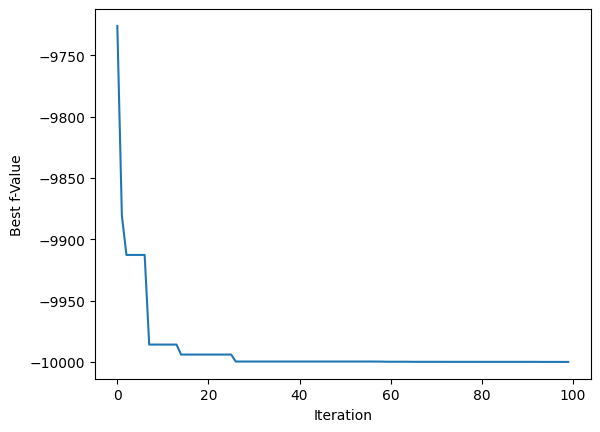

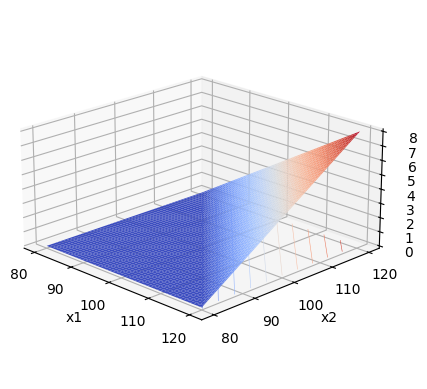

Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).


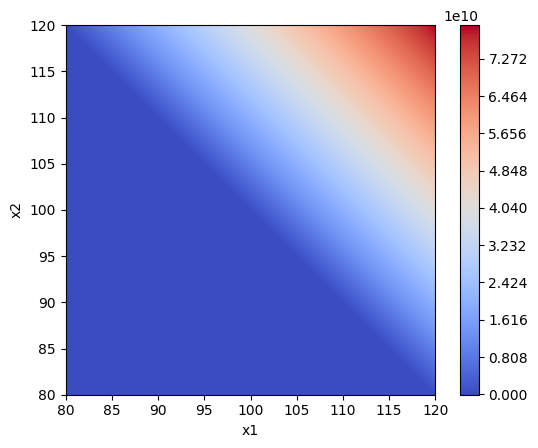

Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).


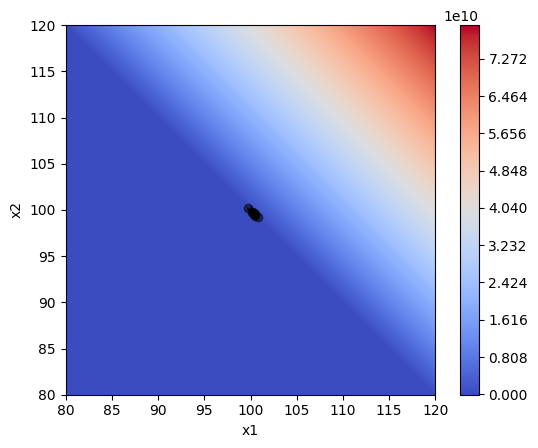

Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).


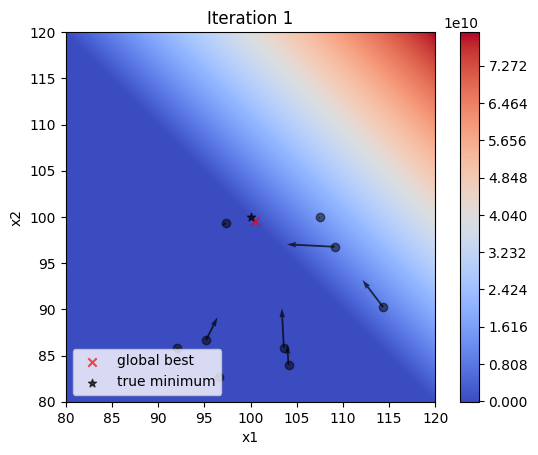

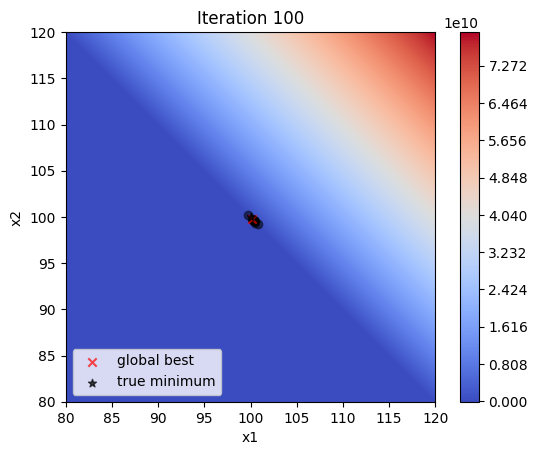

In [129]:

pso = PSO(n=10, dim=2, iterations=100, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f2, lower_bound=-20, upper_bound=20, solution = [100.0, 100.0], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f2')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=99, ite=1000, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: -9957.378049073885 ([105.33084311  94.53430501])
Iteration 2: -9976.563820220872 ([104.13839565  95.80101323])
Iteration 3: -9976.563820220872 ([104.13839565  95.80101323])
Iteration 4: -9976.563820220872 ([104.13839565  95.80101323])
Iteration 5: -9982.204567176927 ([103.83252758  96.13754764])
Iteration 6: -9982.204567176927 ([103.83252758  96.13754764])
Iteration 7: -9982.204567176927 ([103.83252758  96.13754764])
Iteration 8: -9982.204567176927 ([103.83252758  96.13754764])
Iteration 9: -9982.204567176927 ([103.83252758  96.13754764])
Iteration 10: -9982.204567176927 ([103.83252758  96.13754764])
Iteration 11: -9982.204567176927 ([103.83252758  96.13754764])
Iteration 12: -9986.177044569718 ([101.72550974  98.16787421])
Iteration 13: -9986.177044569718 ([101.72550974  98.16787421])
Iteration 14: -9986.177044569718 ([101.72550974  98.16787421])
Iteration 15: -9997.540433244296 ([ 99.03273879 100.9518

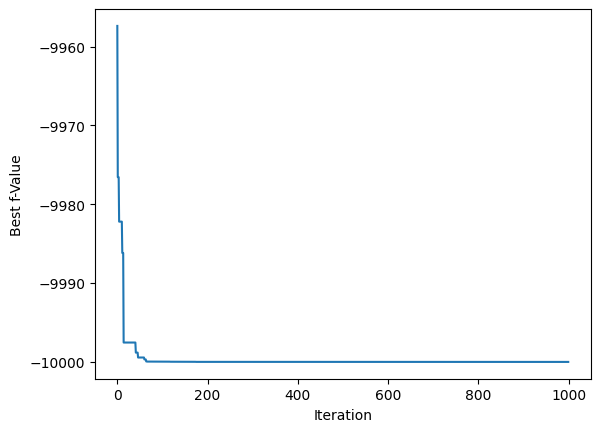

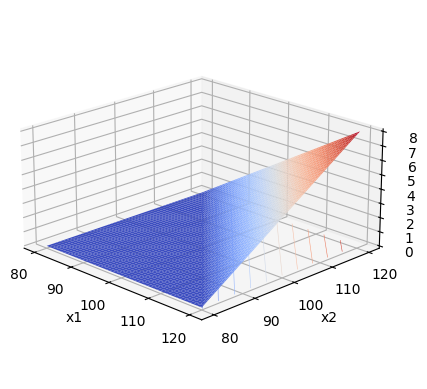

Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).


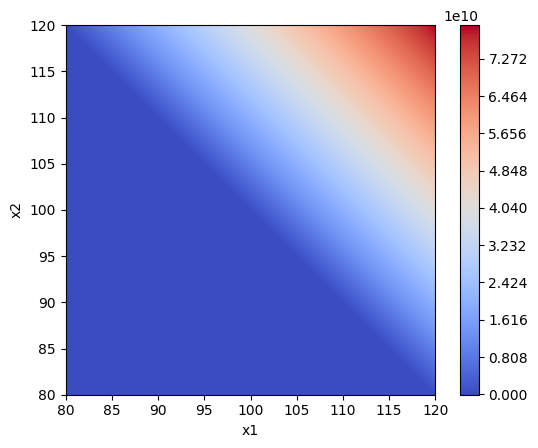

Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).


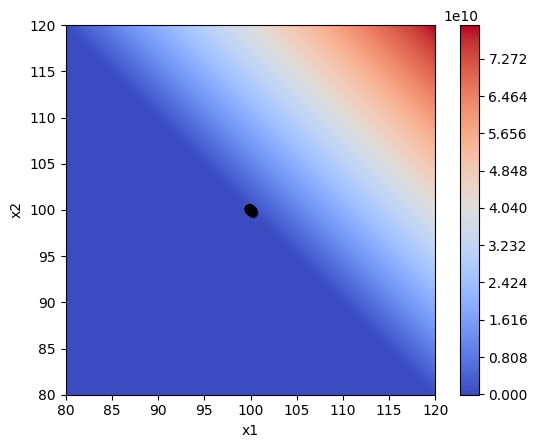

Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1002 ticks ([-80000000.0, ..., 80000000000.0]), which exceeds Locator.MAXTICKS (1000).


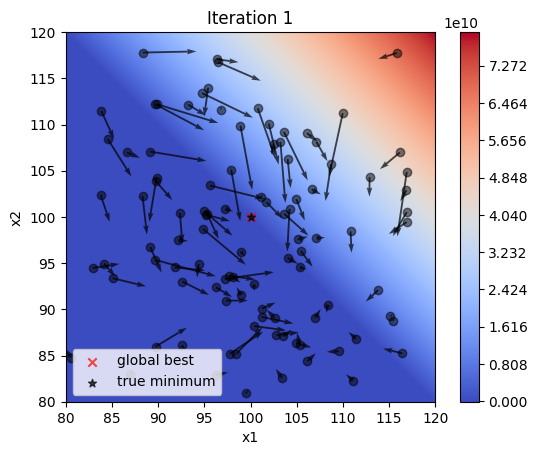

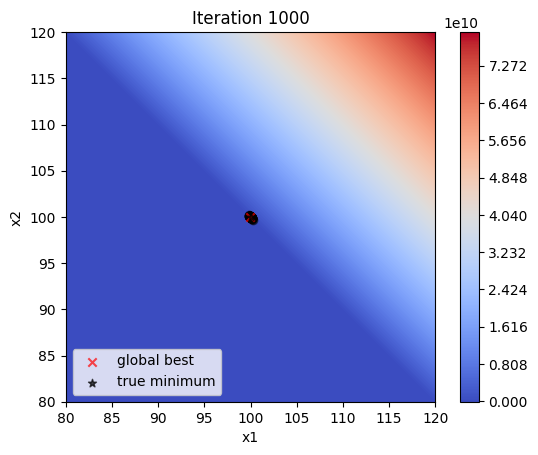

In [130]:

pso = PSO(n=100, dim=2, iterations=1000, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f2, lower_bound=-20, upper_bound=20, solution = [100.0, 100.0], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f2')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)


### Problema 3: Cercar un solar rectangular 2

Min $4(2x + 2y)$

$xy = 400$

Solución: $x=20, y=20$


In [165]:
def f3(x):

    X = np.atleast_2d(x)

    val = 4 * (2 * X[:, 0] + 2 * X[:, 1])

    r0 = 400 - X[:, 0] * X[:, 1]

    val = val + abs(penalty * r0)

    return val

PSO with parameters n=4, ite=10, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 141458462688.24625 ([25.55257417 10.11802318])
Iteration 2: 44200097954.80168 ([25.14774494 14.14838202])
Iteration 3: 31257080345.559563 ([24.82388156 17.3726691 ])
Iteration 4: 13624077497.513647 ([23.14428652 17.87154151])
Iteration 5: 13624077497.513647 ([23.14428652 17.87154151])
Iteration 6: 13624077497.513647 ([23.14428652 17.87154151])
Iteration 7: 13624077497.513647 ([23.14428652 17.87154151])
Iteration 8: 2893622223.805832 ([24.38677723 16.52098668])
Iteration 9: 2893622223.805832 ([24.38677723 16.52098668])
Iteration 10: 2893622223.805832 ([24.38677723 16.52098668])
Time taken: 0.002066 seconds
Global best value: 2893622223.805832 at [24.38677723 16.52098668]


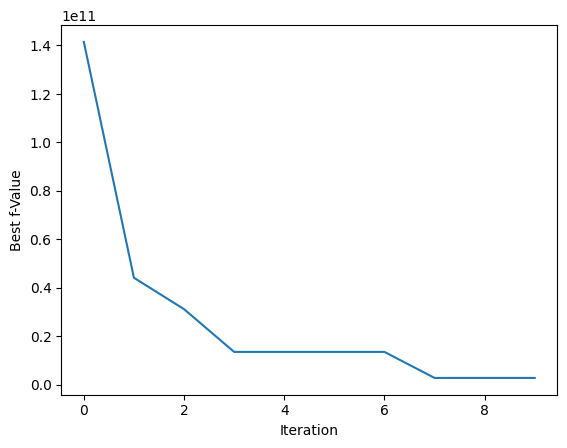

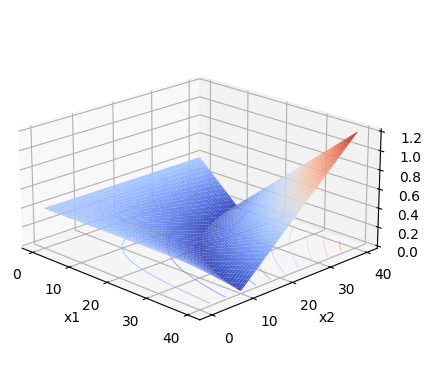

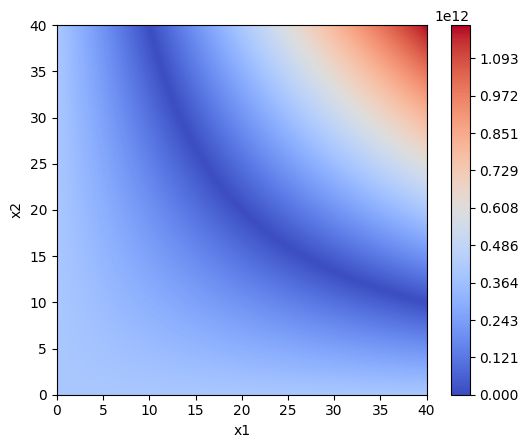

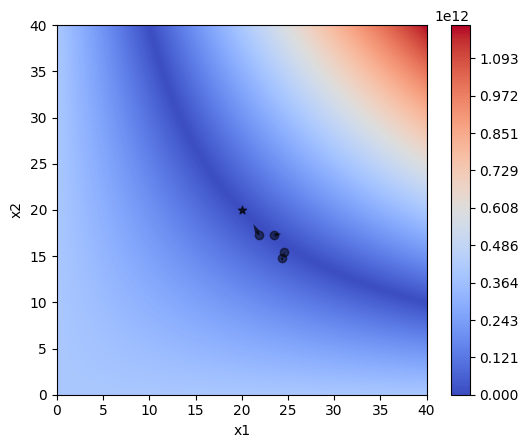

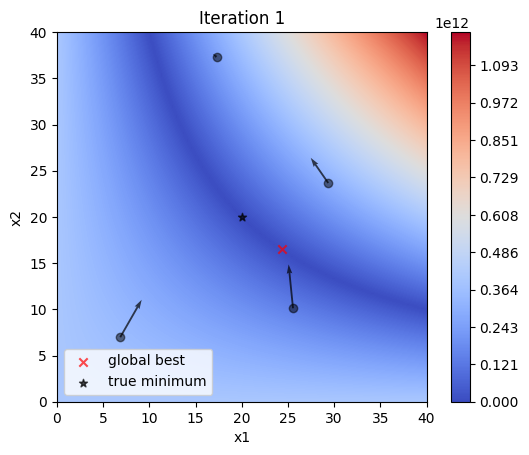

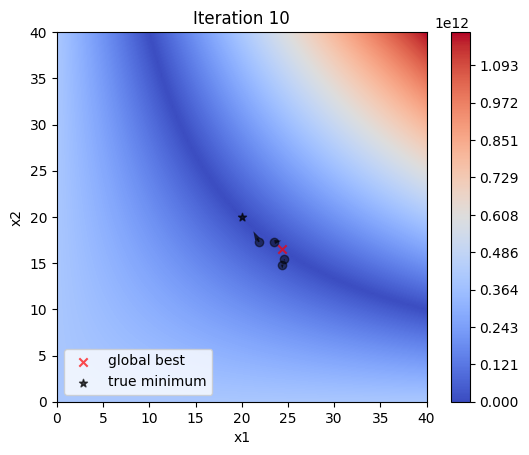

In [132]:
pso = PSO(n=5, dim=2, iterations=10, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f3, lower_bound=-20, upper_bound=20, solution = [20.0, 20.0], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f3')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=9, ite=100, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 21366785332.893787 ([12.28565862 30.81912226])
Iteration 2: 4903199885.039553 ([13.08835017 30.93615272])
Iteration 3: 4903199885.039553 ([13.08835017 30.93615272])
Iteration 4: 4903199885.039553 ([13.08835017 30.93615272])
Iteration 5: 4903199885.039553 ([13.08835017 30.93615272])
Iteration 6: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 7: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 8: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 9: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 10: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 11: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 12: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 13: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 14: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 15: 211035654.1878687 ([12.9242575 30.9658822])
Iteration 16: 211035654.1878687 ([12.9242575 30.9658822])
I

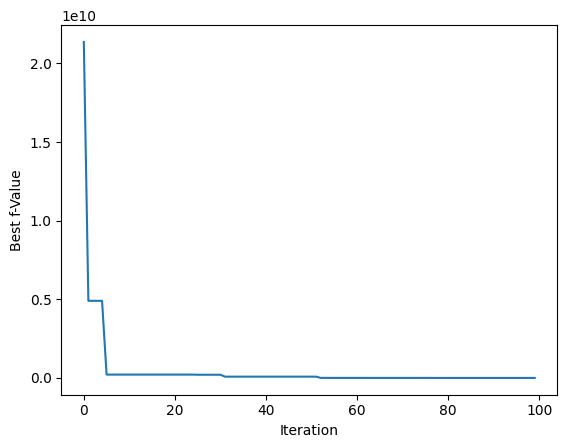

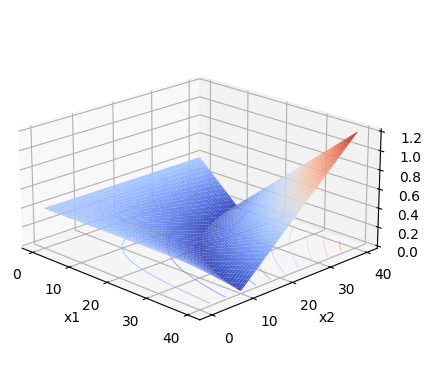

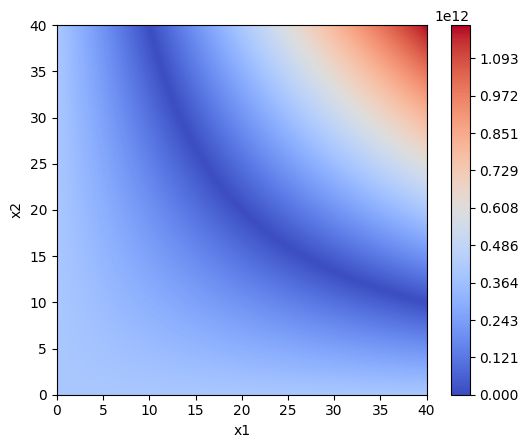

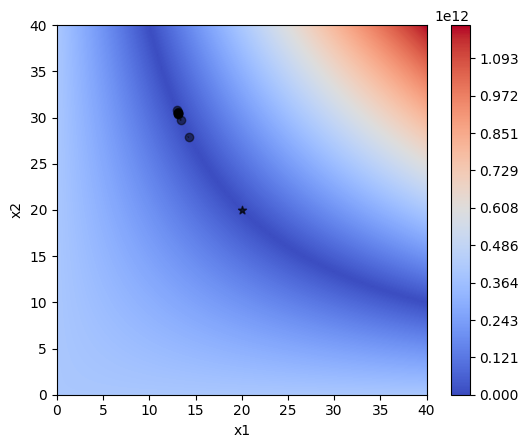

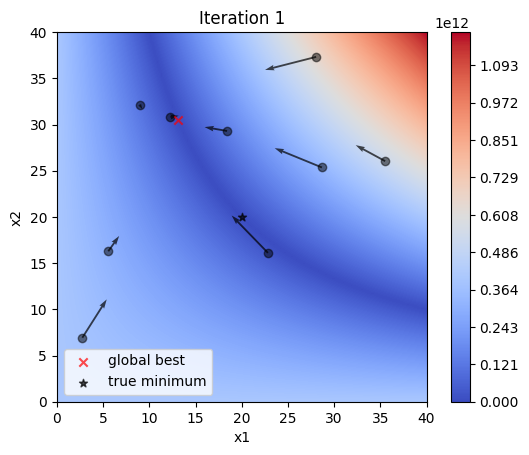

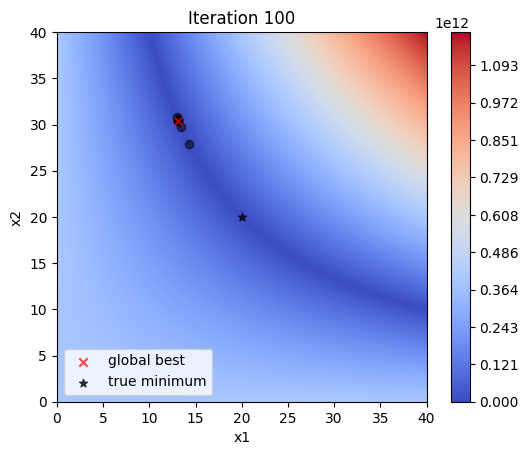

In [133]:
pso = PSO(n=10, dim=2, iterations=100, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f3, lower_bound=-20, upper_bound=20, solution = [20.0, 20.0], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f3')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=999, ite=100, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 222087791.38199335 ([15.67405865 25.50570478])
Iteration 2: 158973369.2661239 ([21.3485486  18.72919019])
Iteration 3: 42966710.11188927 ([17.6600973  22.64749887])
Iteration 4: 19624178.973756682 ([18.96825972 21.08889427])
Iteration 5: 19624178.973756682 ([18.96825972 21.08889427])
Iteration 6: 19624178.973756682 ([18.96825972 21.08889427])
Iteration 7: 19624178.973756682 ([18.96825972 21.08889427])
Iteration 8: 19624178.973756682 ([18.96825972 21.08889427])
Iteration 9: 19624178.973756682 ([18.96825972 21.08889427])
Iteration 10: 19624178.973756682 ([18.96825972 21.08889427])
Iteration 11: 5526732.185273809 ([20.66646708 19.35529304])
Iteration 12: 5526732.185273809 ([20.66646708 19.35529304])
Iteration 13: 5526732.185273809 ([20.66646708 19.35529304])
Iteration 14: 5526732.185273809 ([20.66646708 19.35529304])
Iteration 15: 5526732.185273809 ([20.66646708 19.35529304])
Iteration 16: 5526732.18527380

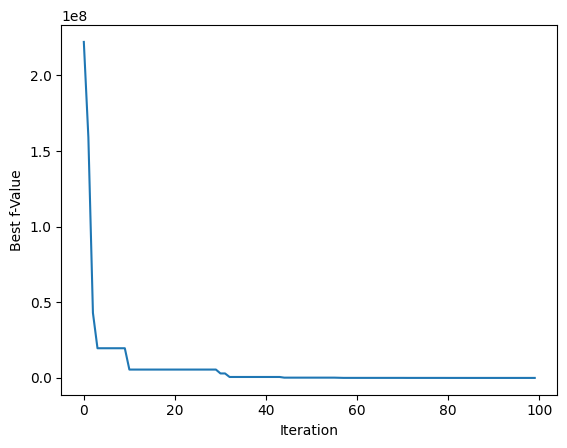

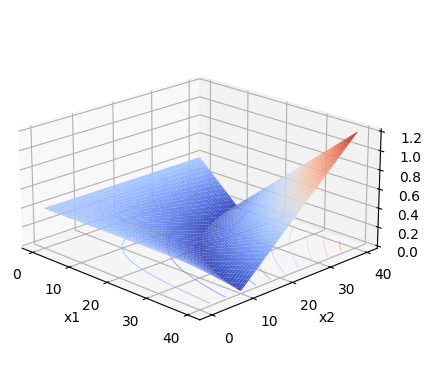

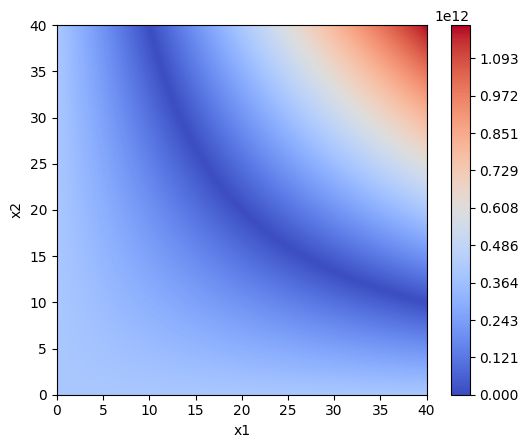

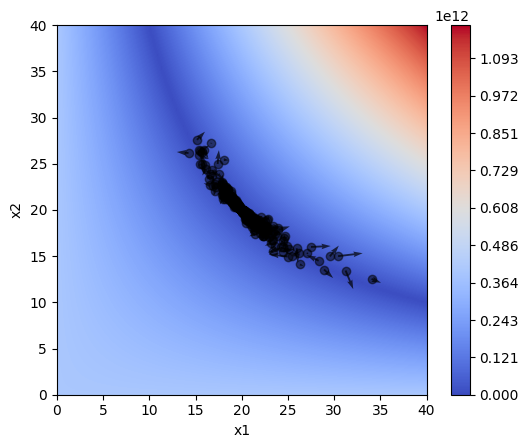

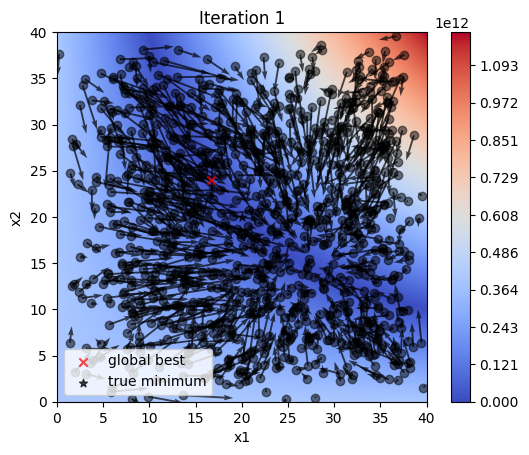

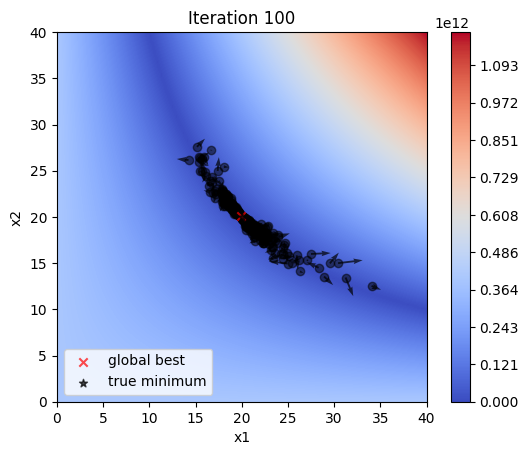

In [170]:
pso = PSO(n=1000, dim=2, iterations=100, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f3, lower_bound=-20, upper_bound=20, solution = [20.0, 20.0], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f3')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

### Problema 4: Ventana

Max $xy + \frac{\sqrt 3}{4}x^2$

$3x + 2y = 6.6$

Solución: $x = 1.54, y = 0.99$

In [144]:
def f4(x):
    
    X = np.atleast_2d(x)

    val = -(X[:, 0] * X[:, 1] + np.sqrt(3) / 4 * X[:, 0] * X[:, 0])

    r0 = 3 * X[:, 0] + 2 * X[:, 1] - 6.6

    val = val + abs(penalty * r0)

    return val

PSO with parameters n=4, ite=10, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 99999998.50213404 ([0.54 2.54])
Iteration 2: 99999998.50213404 ([0.54 2.54])
Iteration 3: 99999998.50213404 ([0.54 2.54])
Iteration 4: 983169.4350147863 ([0.54       2.49049159])
Iteration 5: 983169.4350147863 ([0.54       2.49049159])
Iteration 6: 983169.4350147863 ([0.54       2.49049159])
Iteration 7: 983169.4350147863 ([0.54       2.49049159])
Iteration 8: 983169.4350147863 ([0.54       2.49049159])
Iteration 9: 983169.4350147863 ([0.54       2.49049159])
Iteration 10: 983169.4350147863 ([0.54       2.49049159])
Time taken: 0.002465 seconds
Global best value: 983169.4350147863 at [0.54       2.49049159]


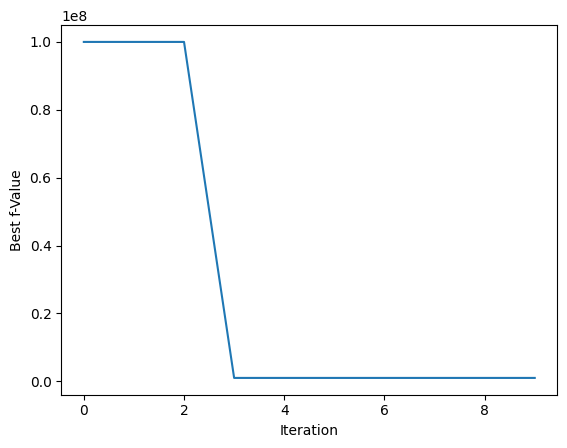

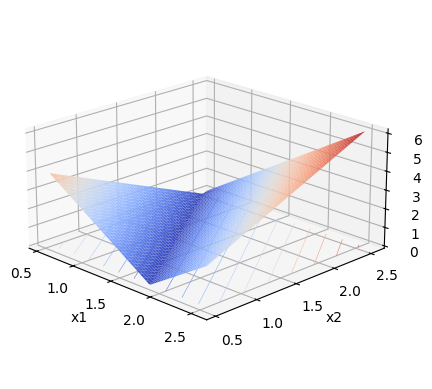

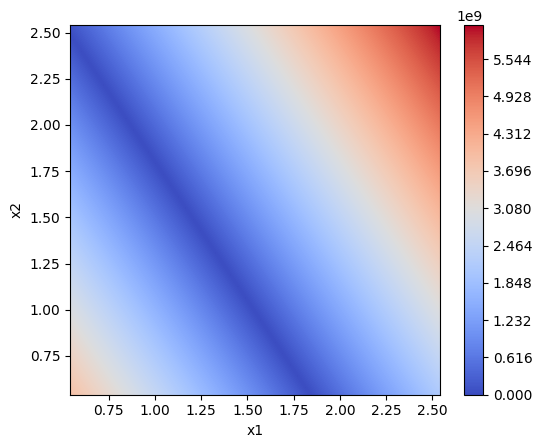

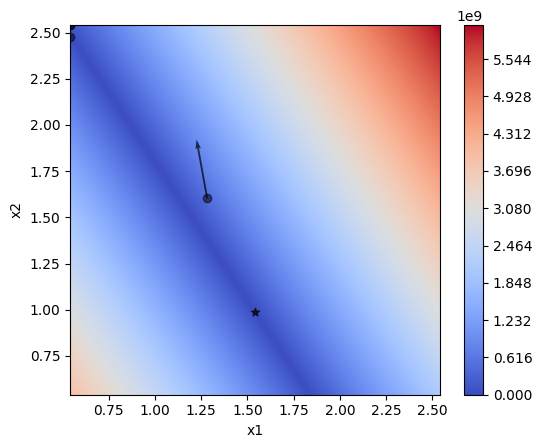

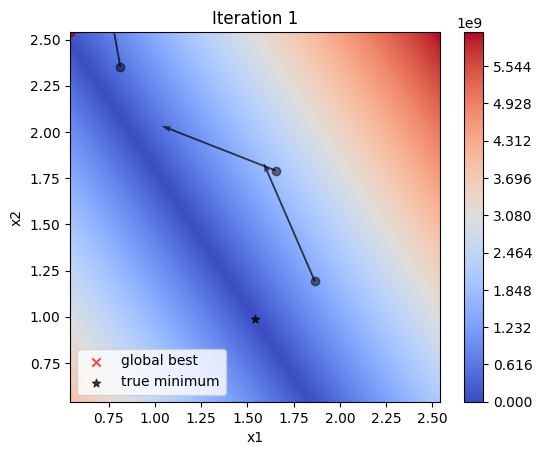

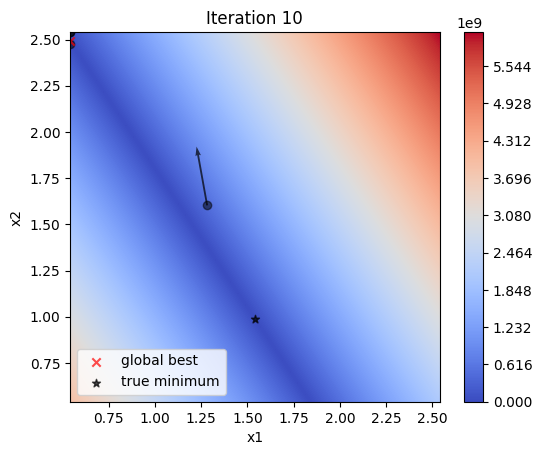

In [136]:
pso = PSO(n=5, dim=2, iterations=10, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f4, lower_bound=-1, upper_bound=1, solution = [1.54, 0.99], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f3')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=9, ite=100, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 113958916.07738887 ([0.63749977 2.28677089])
Iteration 2: 113958916.07738887 ([0.63749977 2.28677089])
Iteration 3: 113958916.07738887 ([0.63749977 2.28677089])
Iteration 4: 77051492.53392948 ([1.26176121 1.36883243])
Iteration 5: 77051492.53392948 ([1.26176121 1.36883243])
Iteration 6: 77051492.53392948 ([1.26176121 1.36883243])
Iteration 7: 17032301.766587157 ([1.06867823 1.70549881])
Iteration 8: 17032301.766587157 ([1.06867823 1.70549881])
Iteration 9: 17032301.766587157 ([1.06867823 1.70549881])
Iteration 10: 17032301.766587157 ([1.06867823 1.70549881])
Iteration 11: 17032301.766587157 ([1.06867823 1.70549881])
Iteration 12: 17032301.766587157 ([1.06867823 1.70549881])
Iteration 13: 17032301.766587157 ([1.06867823 1.70549881])
Iteration 14: 17032301.766587157 ([1.06867823 1.70549881])
Iteration 15: 17032301.766587157 ([1.06867823 1.70549881])
Iteration 16: 1653543.1269587502 ([0.97663738 1.83421716])

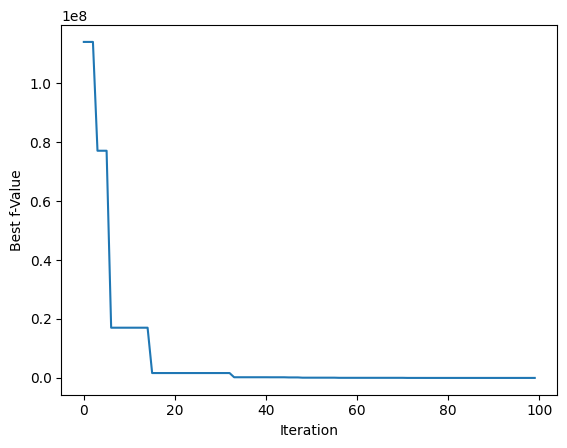

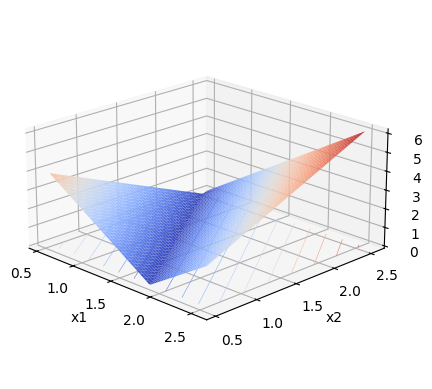

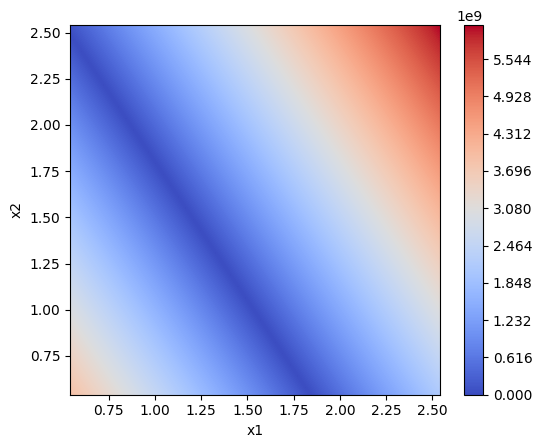

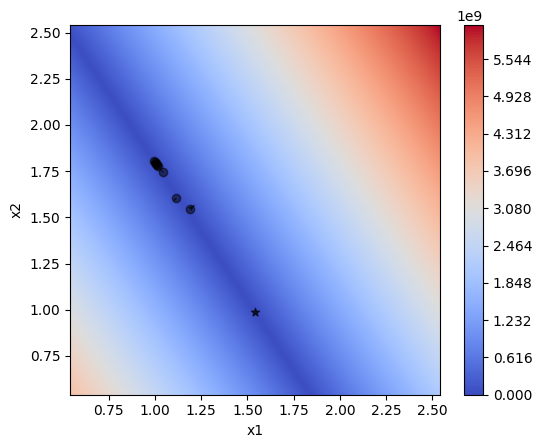

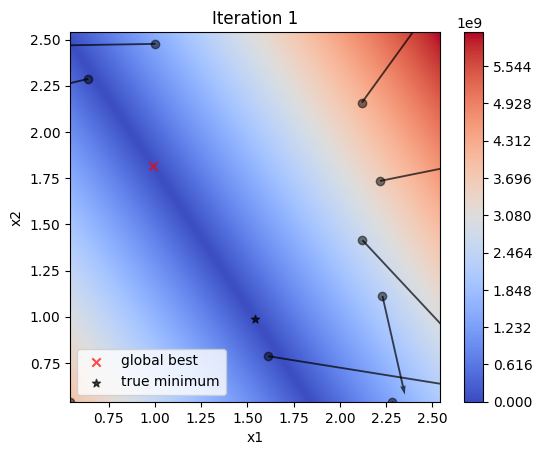

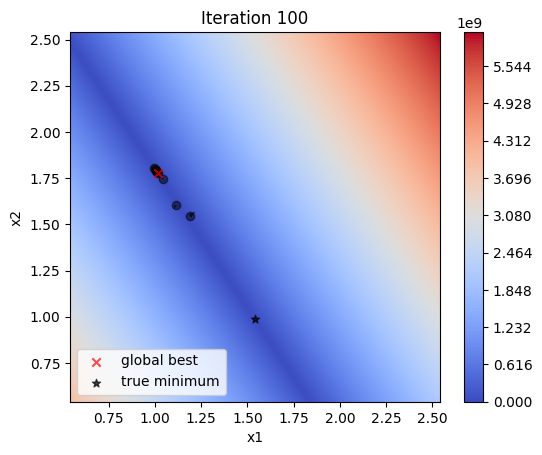

In [137]:
pso = PSO(n=10, dim=2, iterations=100, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f4, lower_bound=-1, upper_bound=1, solution = [1.54, 0.99], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f3')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=999, ite=1000, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 1763885.0510460534 ([1.46160285 1.10847766])
Iteration 2: 1085572.122357734 ([1.84036186 0.54      ])
Iteration 3: 1085572.122357734 ([1.84036186 0.54      ])
Iteration 4: 1085572.122357734 ([1.84036186 0.54      ])
Iteration 5: 222452.10569140135 ([1.75820704 0.66257821])
Iteration 6: 222452.10569140135 ([1.75820704 0.66257821])
Iteration 7: 112181.32757984355 ([1.83996261 0.54      ])
Iteration 8: 112181.32757984355 ([1.83996261 0.54      ])
Iteration 9: 112181.32757984355 ([1.83996261 0.54      ])
Iteration 10: 112181.32757984355 ([1.83996261 0.54      ])
Iteration 11: 10858.154164869773 ([1.468587   1.09712492])
Iteration 12: 10858.154164869773 ([1.468587   1.09712492])
Iteration 13: 10858.154164869773 ([1.468587   1.09712492])
Iteration 14: 10858.154164869773 ([1.468587   1.09712492])
Iteration 15: 10858.154164869773 ([1.468587   1.09712492])
Iteration 16: 10858.154164869773 ([1.468587   1.0971249

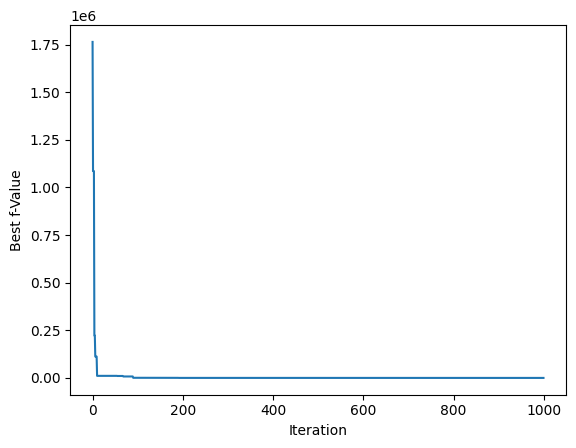

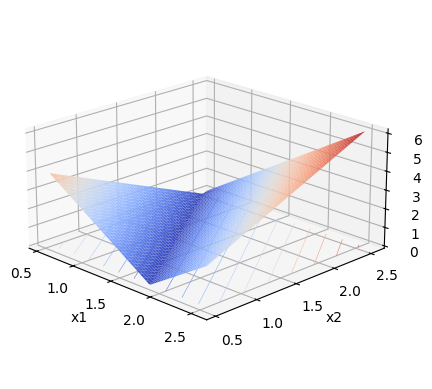

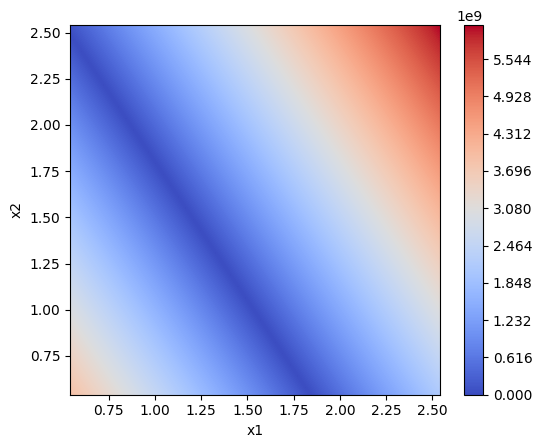

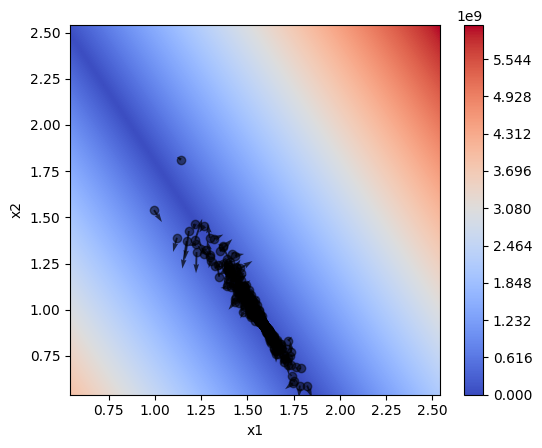

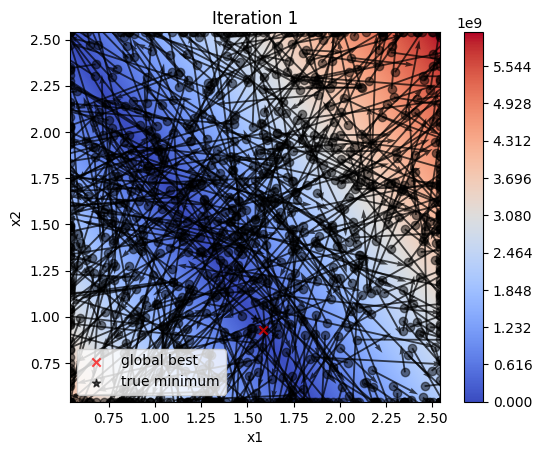

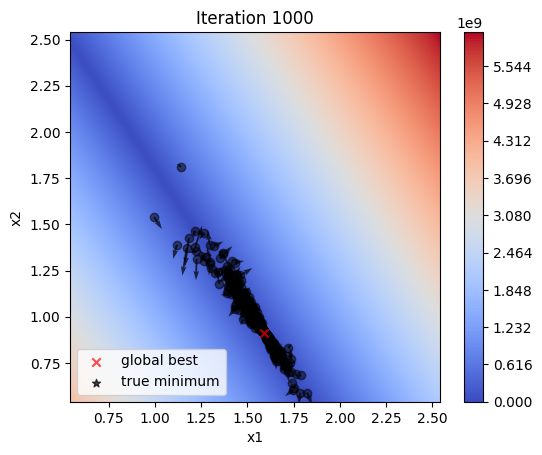

In [164]:
pso = PSO(n=1000, dim=2, iterations=1000, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f4, lower_bound=-1, upper_bound=1, solution = [1.54, 0.99], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f3')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

### Problema 5: Jardín rectangular en terreno circular

Max $xy$

$x^2 + y^2 = 40000$

Solución: $x = 100 \sqrt 2, y = 100 \sqrt 2$

In [171]:
def f5(x):

    X = np.atleast_2d(x)

    val = -(X[:, 0] * X[:, 1])

    r0 = X[:, 0] * X[:, 0] + X[:, 1] * X[:, 1] - 40000

    val = val + abs(penalty * r0)

    return val

PSO with parameters n=4, ite=10, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 537323916804.5774 ([127.97767288 155.43178305])
Iteration 2: 461572748645.31836 ([127.02355431 155.96983497])
Iteration 3: 367792048758.1808 ([126.72242762 155.91413793])
Iteration 4: 297579609360.24 ([126.49658261 155.87236515])
Iteration 5: 248493675395.5734 ([126.3384911  155.84312421])
Iteration 6: 141855226137.24673 ([156.69230242 124.85742913])
Iteration 7: 141855226137.24673 ([156.69230242 124.85742913])
Iteration 8: 141855226137.24673 ([156.69230242 124.85742913])
Iteration 9: 141855226137.24673 ([156.69230242 124.85742913])
Iteration 10: 141855226137.24673 ([156.69230242 124.85742913])
Time taken: 0.002255 seconds
Global best value: 141855226137.24673 at [156.69230242 124.85742913]


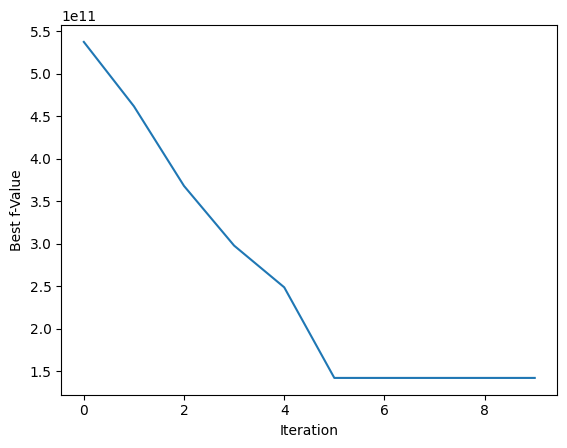

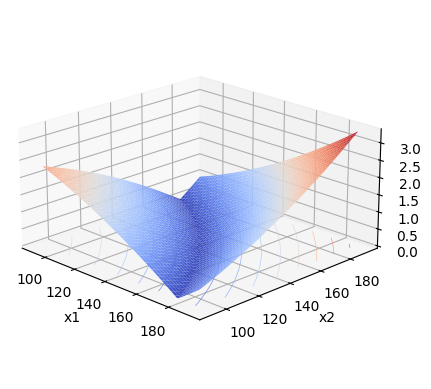

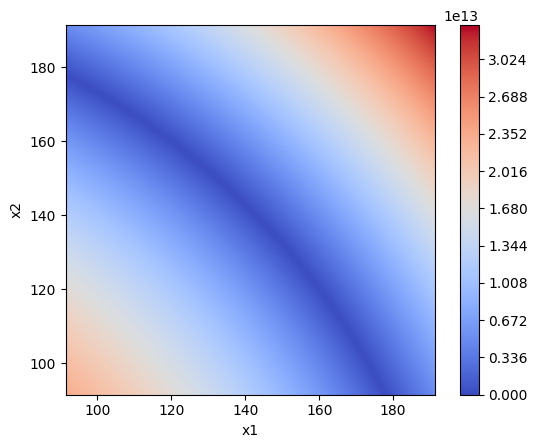

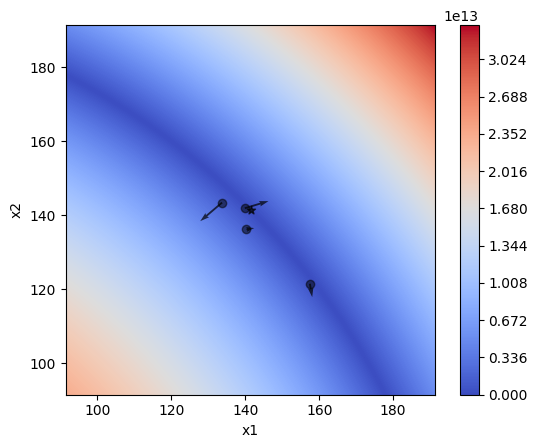

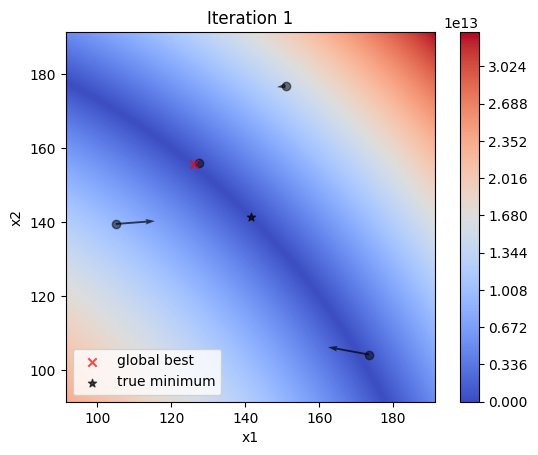

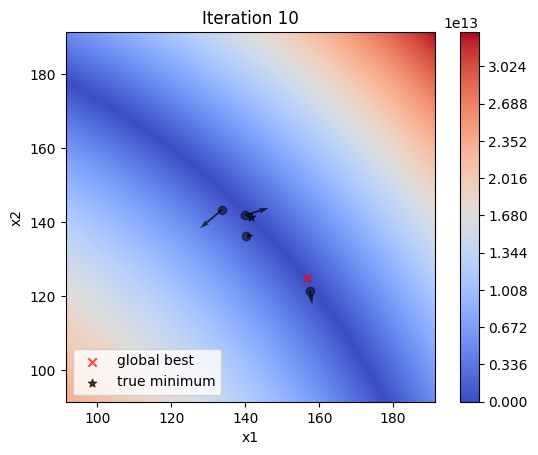

In [140]:
pso = PSO(n=5, dim=2, iterations=10, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f5, lower_bound=-50, upper_bound=50, solution = [100 * np.sqrt(2), 100 * np.sqrt(2)], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f3')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=9, ite=100, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 314556620912.4275 ([108.4400393  167.11134383])
Iteration 2: 314556620912.4275 ([108.4400393  167.11134383])
Iteration 3: 314556620912.4275 ([108.4400393  167.11134383])
Iteration 4: 253751923366.313 ([108.69245848 167.12928387])
Iteration 5: 75016301251.77904 ([109.17048938 167.35228689])
Iteration 6: 75016301251.77904 ([109.17048938 167.35228689])
Iteration 7: 65975166428.17024 ([109.28038669 167.30756677])
Iteration 8: 12665885173.993315 ([109.35143432 167.4960588 ])
Iteration 9: 12665885173.993315 ([109.35143432 167.4960588 ])
Iteration 10: 12665885173.993315 ([109.35143432 167.4960588 ])
Iteration 11: 12665885173.993315 ([109.35143432 167.4960588 ])
Iteration 12: 3783164414.0751348 ([108.71616241 167.86009904])
Iteration 13: 3783164414.0751348 ([108.71616241 167.86009904])
Iteration 14: 3783164414.0751348 ([108.71616241 167.86009904])
Iteration 15: 3783164414.0751348 ([108.71616241 167.86009904])
Ite

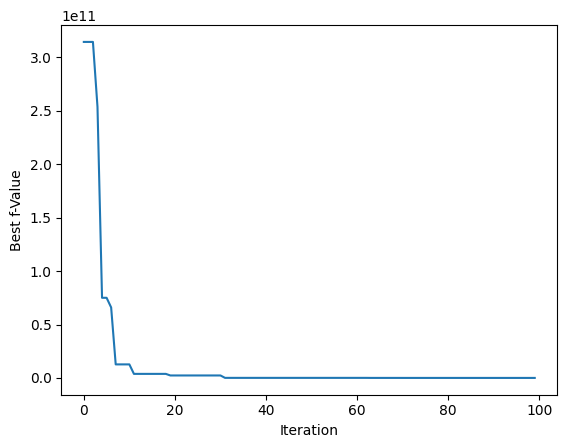

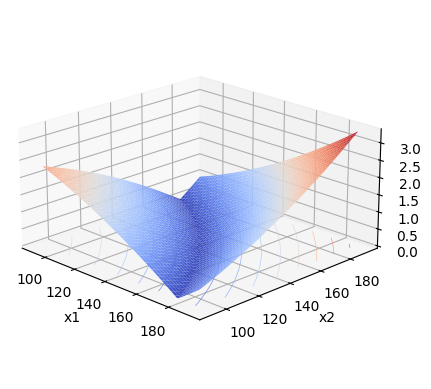

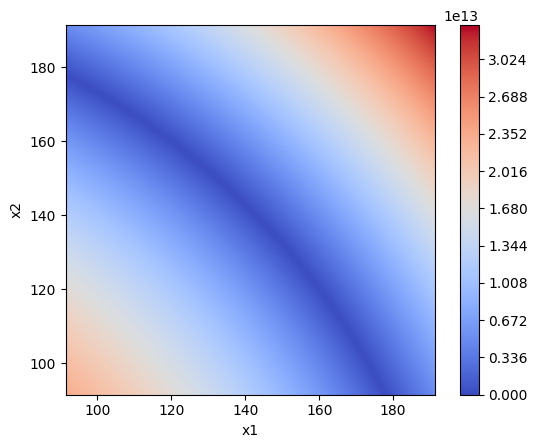

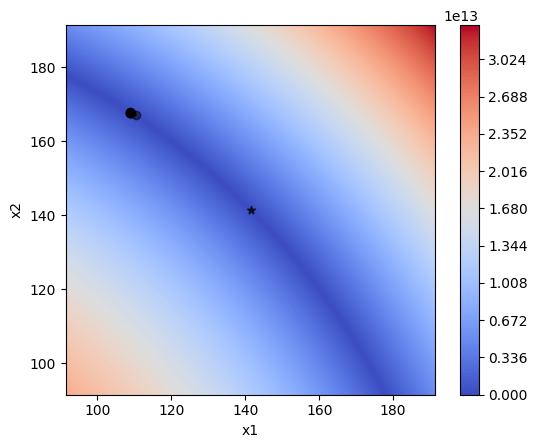

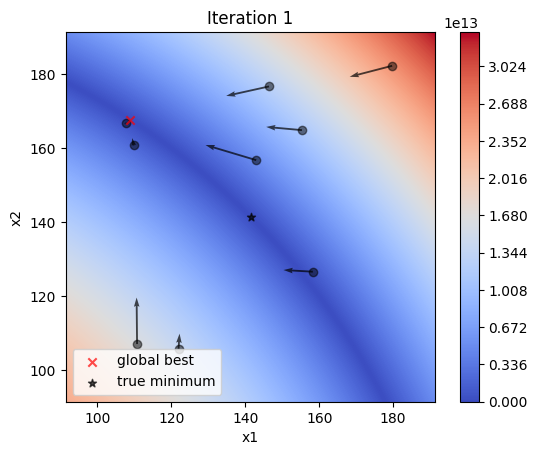

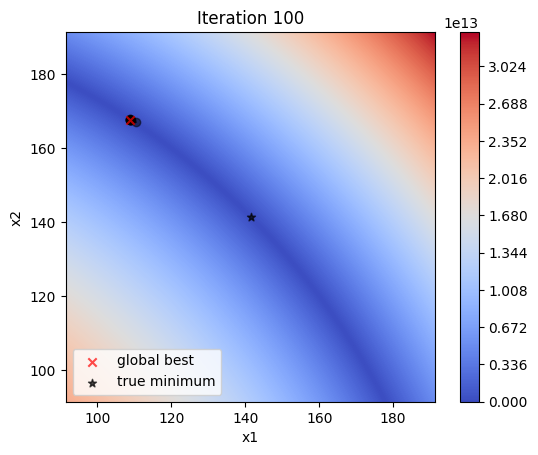

In [141]:
pso = PSO(n=10, dim=2, iterations=100, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f5, lower_bound=-50, upper_bound=50, solution = [100 * np.sqrt(2), 100 * np.sqrt(2)], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f3')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)

PSO with parameters n=999, ite=1000, c1=0.8, c2=0.3, wmax=0.9, wmin=0.4
Iteration 1: 4147204567.527784 ([151.67302934 130.38189827])
Iteration 2: 4147204567.527784 ([151.67302934 130.38189827])
Iteration 3: 4147204567.527784 ([151.67302934 130.38189827])
Iteration 4: 1980443563.7436445 ([135.51607535 147.08301349])
Iteration 5: 1980443563.7436445 ([135.51607535 147.08301349])
Iteration 6: 1980443563.7436445 ([135.51607535 147.08301349])
Iteration 7: 1980443563.7436445 ([135.51607535 147.08301349])
Iteration 8: 1200410245.767488 ([141.22409294 141.62258295])
Iteration 9: 718945443.1749363 ([147.29131284 135.29962353])
Iteration 10: 718945443.1749363 ([147.29131284 135.29962353])
Iteration 11: 290913979.24324614 ([140.11295377 142.71878335])
Iteration 12: 290913979.24324614 ([140.11295377 142.71878335])
Iteration 13: 290913979.24324614 ([140.11295377 142.71878335])
Iteration 14: 290913979.24324614 ([140.11295377 142.71878335])
Iteration 15: 290913979.24324614 ([140.11295377 142.71878335]

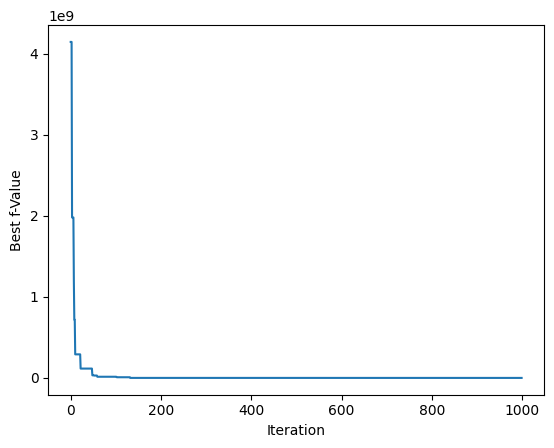

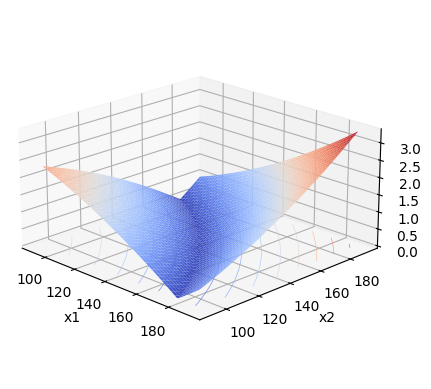

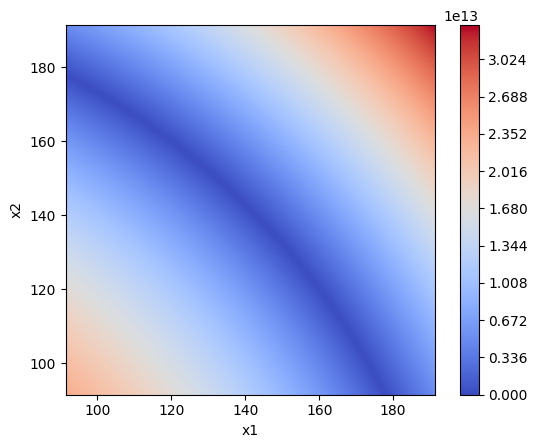

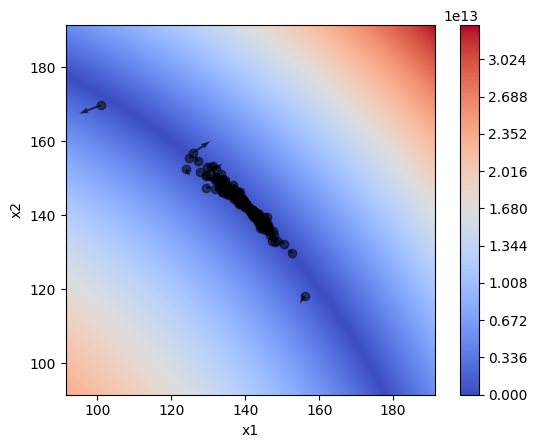

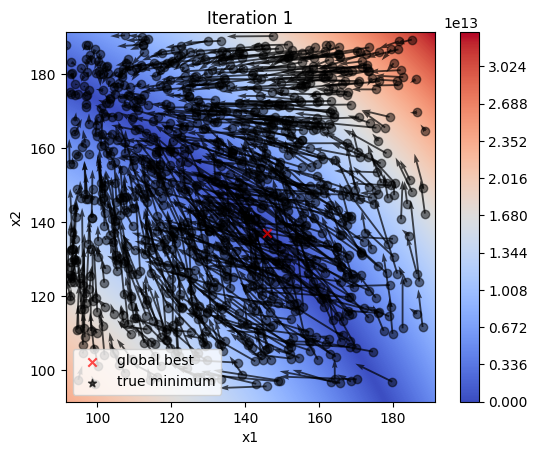

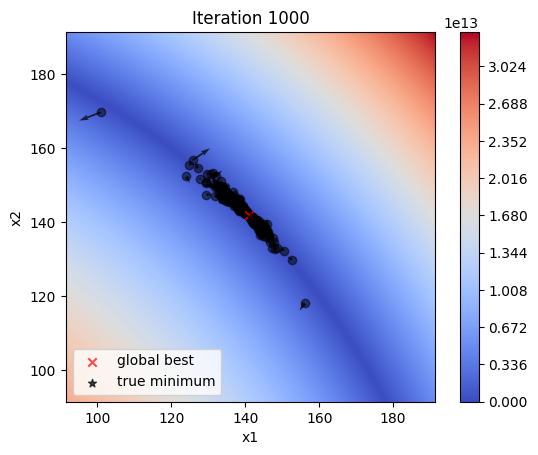

In [210]:
pso = PSO(n=1000, dim=2, iterations=1000, c1=0.8, c2=0.3, w_max=0.9, w_min=0.4, f=f5, lower_bound=-50, upper_bound=50, solution = [100 * np.sqrt(2), 100 * np.sqrt(2)], early_stop=False)
pso.optimize()
pso.plot_convergence()
pso.plot_objective_function()
pso.plot_animation(filename='f3')
pso.plot_frame(0)
pso.plot_frame(pso.iterations - 1)